# CS-472 Computer Vision
## Assignment 05: Particle Swarm Optimization Tracking
## By: <span style="color:orange">Ioannis Kaziales</span> ~ csdp1305
### Spring semester 2022-2023 (Due Date: 03/07/2023)

This file contains a **demo for part C** (video ellipse card tracking).
It contains visualization of the image preprocessing and ellipse parameter estimation process.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from utils import *

np.random.seed(42)

## Dummy Example: find an ellipse on a black background
As a first test, let's create a simple white ellipse on a black background and check how well our PSO implementation will approximate the parameters $(x=500, y=300, \alpha = 250, \beta = 175, \theta = 30^\circ)$

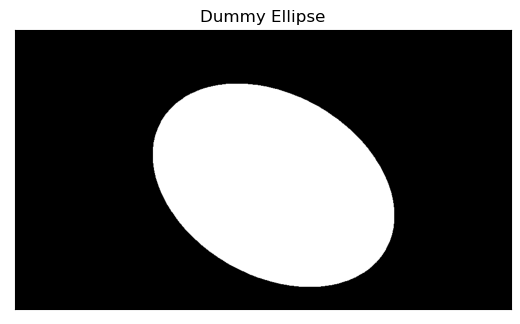

In [2]:
# create a black image
img_dimensions = (540, 960, 3)
img = np.zeros(img_dimensions, np.uint8)

# draw a white ellipse at the center of the image
center = (500, 300) # x, y
axes = (250, 175)   # a, b
angle = 30          # clockwise, first axis, starts horizontal
img = cv2.ellipse(img, center, axes, angle, 0, 360, (255, 255, 255), -1)

plt.imshow(img)
plt.xticks([]), plt.yticks([])
plt.title('Dummy Ellipse')
plt.show()

Original  ellipse: center: (500, 300), axes: (250, 175), angle: 30
Estimated ellipse: center: (500, 300), axes: (250, 176), angle: 29


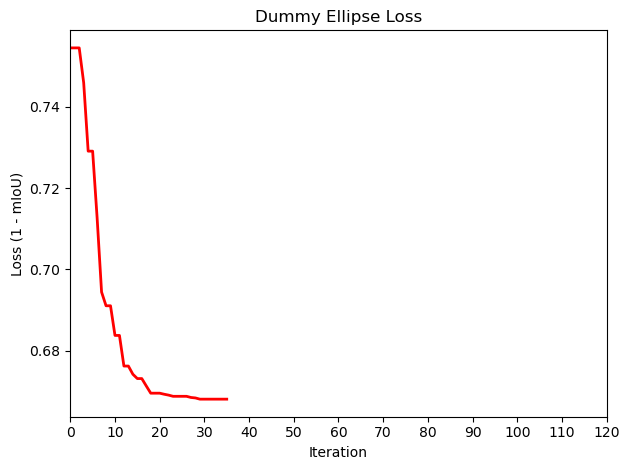

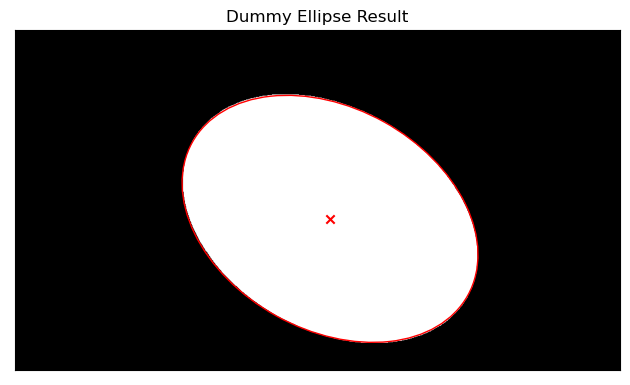

In [3]:
# PSO parameters for the first frame
num_particles = 20
max_iterations = 120
stop_iterations = 6    # stop if no improvement after 15 iterations
c1 = 1.0                # cognitive parameter
c2 = 1.0                # social parameter
w  = 0.7                # inertia weight
decay = 0.98             # decay of inertia

y_max, x_max = img_dimensions[:2]
# find the max axis that an ellipse can have as the length of the diagonal
max_axis = int(np.sqrt(x_max**2 + y_max**2))
max_angle = 180

max_position = [x_max, y_max, max_axis, max_axis, max_angle]

particles = initialize_particles(img, num_particles, max_position)

optim = ParticleSwarmOptimizer(num_particles, max_iterations, c1, c2, w, decay, stop_iterations)
best_position, best_fitness, losses = optim.optimize(img, particles, max_position)

x, y, a, b, theta = best_position
# make sure that a is the major axis -> swap if necessary
if a < b:
    a, b = b, a
    theta = (theta + 90) % 180

print(f"Original  ellipse: center: ({center[0]}, {center[1]}), axes: ({axes[0]}, {axes[1]}), angle: {angle}")
print(f"Estimated ellipse: center: ({x}, {y}), axes: ({a}, {b}), angle: {theta}")

filename = None # f'{file_prefix}_loss.png'
plot_loss(losses, title=f'Dummy Ellipse Loss', max_iterations=max_iterations, save_filename=filename)

filename = None # f'{file_prefix}_final.png'
plot_estimation(img, best_position, title=f'Dummy Ellipse Result', save_filename=filename, est_type='ellipse')

### Success!
The calculated parameters are very close to the theoretical ones

## Let's move to more realistic examples from dataset 3

In [4]:
in_dir = "askisi5_dataset3"
SAVE_IMGS: bool = False  # Set to True to save images to disk

if SAVE_IMGS:
    out_dir = "demos_output/partC"
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)

prefix = "colorFrame_0_"

# Testing on `dataset_3/frame_0`
Let's try to find the parameters of the ellipse for the frame 0.


### First, we load the image and plot the intermediate preprocessing steps
Our goal is to turn the complex images of dataset3 to simpler ones, that the PSO algorithm from part A (with mIoU evaluation function) will be able to process more easilly and robustly. So, ideally, we would want each image to contain just a white ellipse and black background. Let's see in detail the process we follow. The code for the preprocessing is implemented in the function `preprocess_image_ellipse` of `utils.py`, but we also show it here:

In [5]:
frame_num = 0
img = cv2.imread(os.path.join(in_dir, f"{prefix}{str(frame_num).zfill(5)}.jpg"))
y_max, x_max = img.shape[:2]

# threshold the image to get a binary image (thresholh AND adaptive threshold yields better results)
threshold = 190
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_adaptive = cv2.adaptiveThreshold(img_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 501, -25)
img_thresh = cv2.threshold(img_gray, threshold, 255, cv2.THRESH_BINARY)[1]
img_binary = cv2.bitwise_and(img_adaptive, img_thresh)

# apply morphological operations to remove noise.
# first close the image to remove small holes inside the ellipse
# then open the image to remove noise outside the ellipse
# finally dilate the image to make the ellipse thicker
close_size = 70
open_size = 150
dilation_size = round(0.5 * open_size)

kernel_close  = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (close_size, close_size))
kernel_open   = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (open_size, open_size))
kernel_dilate = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (dilation_size, dilation_size))
closed = cv2.morphologyEx(img_binary, cv2.MORPH_CLOSE, kernel_close)
opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel_open)
mask   = cv2.dilate(opened, kernel_dilate, iterations=1)
img_preprocessed = cv2.bitwise_and(img_binary, img_binary, mask=mask)

### Time to visualize the intermediate steps of Pre-processing

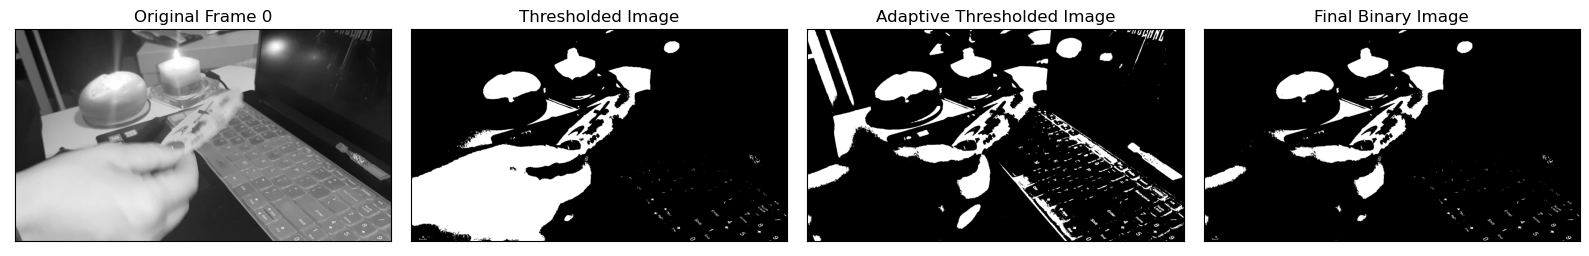

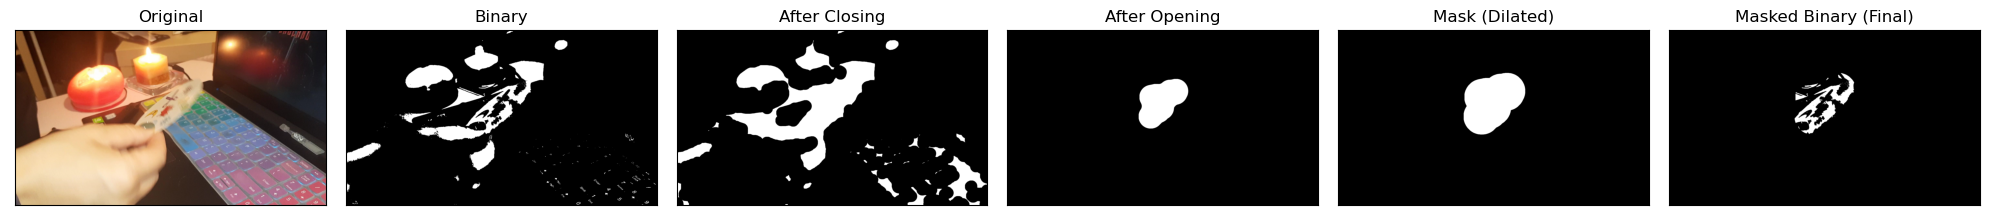

In [6]:
# --------------- SHOW THE INTERMEDIATE STEPS TO GET THE BINARY IMAGE ---------------
plt.figure(figsize=(16, 4))
# show original image
plt.subplot(1, 4, 1),   plt.title(f"Original Frame {frame_num}")
plt.imshow(img_gray, cmap="gray")
# show the thresholded image
plt.subplot(1, 4, 2),   plt.title("Thresholded Image")
plt.imshow(img_thresh, cmap="gray")
# show the adaptive threshold of the image
plt.subplot(1, 4, 3),   plt.title("Adaptive Thresholded Image")
plt.imshow(img_adaptive, cmap="gray")
# show the final binary image -> AND of the two thresholded images
plt.subplot(1, 4, 4),   plt.title("Final Binary Image")
plt.imshow(img_binary, cmap="gray")

plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
plt.tight_layout()
plt.show()


# --------------- SHOW THE INTERMEDIATE STEPS TO GET THE FINAL PREPROCESSED IMAGE ---------------
plt.figure(figsize=(20, 6))
# show original image
plt.subplot(1, 6, 1),   plt.title(f"Original")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
# show the binary image
plt.subplot(1, 6, 2),   plt.title("Binary")
plt.imshow(img_binary, cmap="gray")
# apply closing to fill the ellipse
plt.subplot(1, 6, 3),   plt.title("After Closing")
plt.imshow(closed, cmap="gray")
# apply opening with big kernel to remove background noise
plt.subplot(1, 6, 4),   plt.title("After Opening")
plt.imshow(opened, cmap="gray")
# apply dilation to make the ellipse bigger
plt.subplot(1, 6, 5),   plt.title("Mask (Dilated)")
plt.imshow(mask, cmap="gray")
# apply mask to original image
plt.subplot(1, 6, 6),   plt.title("Masked Binary (Final)")
plt.imshow(img_preprocessed, cmap="gray")
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
plt.tight_layout()
plt.show()

### Let's run the PSO algorithm now
Since it is the first frame, we have no prior knowledge about the parameters of the ellipse

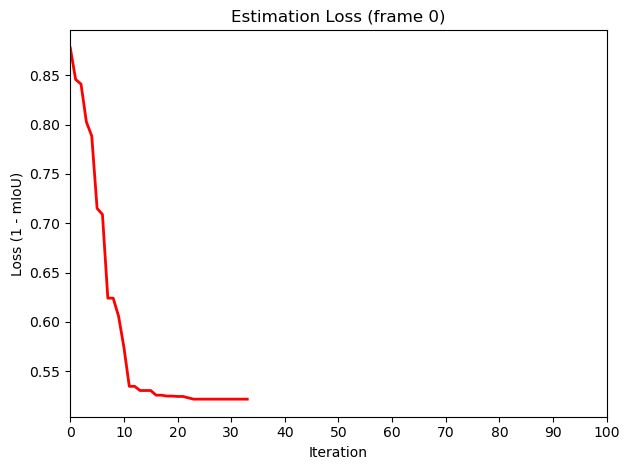

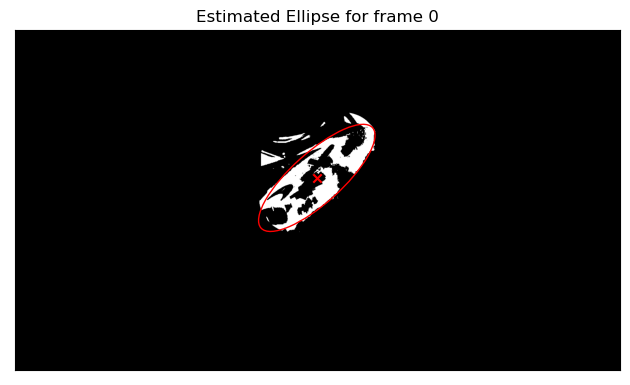

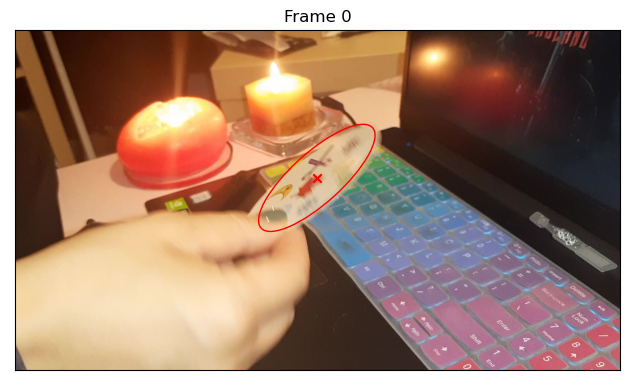

In [7]:
# define the maximum values for the parameters of an ellipse
max_axis    = round(np.sqrt(x_max**2 + y_max**2) / 5)
max_angle   = 180
max_position = [x_max, y_max, max_axis, max_axis, max_angle]

# PSO parameters for the first frame
num_particles = 25
max_iterations = 100
stop_iterations = 10    # stop if no improvement after 15 iterations
c1 = 1.0                # cognitive parameter
c2 = 1.0                # social parameter
w  = 0.7                # inertia weight
decay = 1.0             # decay of inertia

# run the PSO algorithm
particles = initialize_particles(img_preprocessed, num_particles, max_position)
optim = ParticleSwarmOptimizer(num_particles, max_iterations, c1, c2, w, decay, stop_iterations)
best_position, best_fitness, losses = optim.optimize(img_preprocessed, particles, max_position)

plot_loss(losses, title=f'Estimation Loss (frame {frame_num})', max_iterations=max_iterations, save_filename=None)
plot_estimation(img_preprocessed, best_position, title=f"Estimated Ellipse for frame {frame_num}", save_filename=None, est_type='ellipse', rgb=True)
plot_estimation(img, best_position, title=f"Frame {frame_num}", save_filename=None, est_type='ellipse', rgb=True)

## Next Image
Now, let's estimate the parameters for the next frame. First, we load the image and initialize the particles randomly

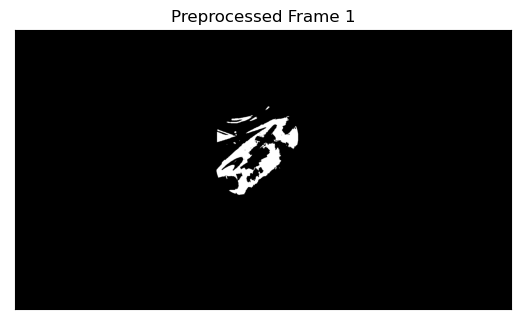

In [8]:
frame_num += 1
img = cv2.imread(os.path.join(in_dir, f"{prefix}{str(frame_num).zfill(5)}.jpg"))
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# modify the preprocessing parameters, acording to the estimation of the previous frame
x, y, a, b, theta = best_position
close_size = round(0.5 * min(best_position[2], best_position[3]))
close_size = np.clip(close_size, 65, 105).astype(int)
img_preprocessed = preprocess_image_ellipse(img_gray, close_size=close_size)

plt.figure()
plt.imshow(img_preprocessed, cmap="gray")
plt.title(f"Preprocessed Frame {frame_num}")
plt.xticks([])
plt.yticks([])
plt.show()

Let's visualize the best global position found for the previous frame on the new frame

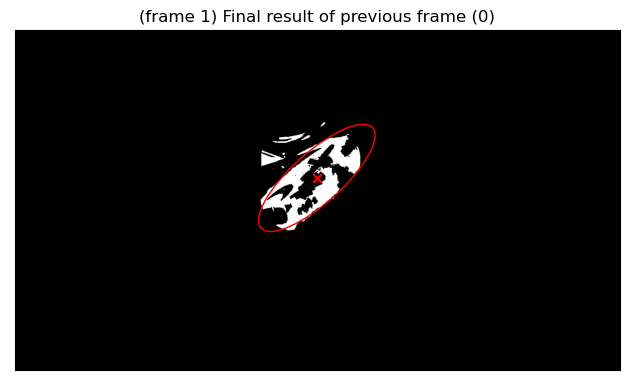

In [9]:
title = f"(frame {frame_num}) Final result of previous frame ({frame_num-1})"
plot_estimation(img_preprocessed, best_position, title=title, save_filename=None, est_type='ellipse', rgb=True)

### Temporally Smooth Movement
We can observe that circles in successive image frames have similar parameters. We can utilize this observation as prior knowledge for each new frame, given that we have successfully identified the circle from the previous frame. Specifically, the previous best global position can serve as an estimate for the new position. In addition to that, we can modify the parameters to achieve faster convergence!

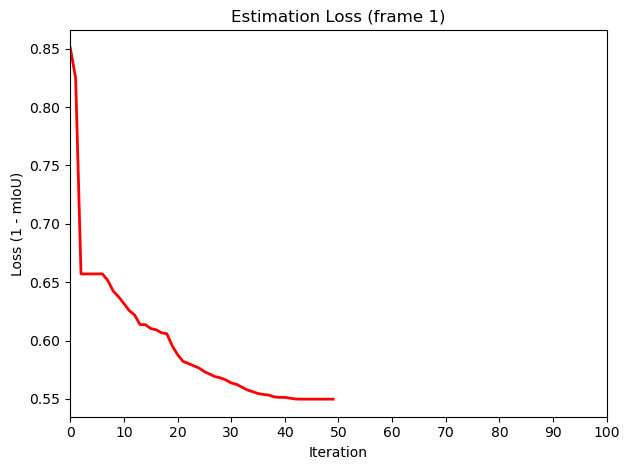

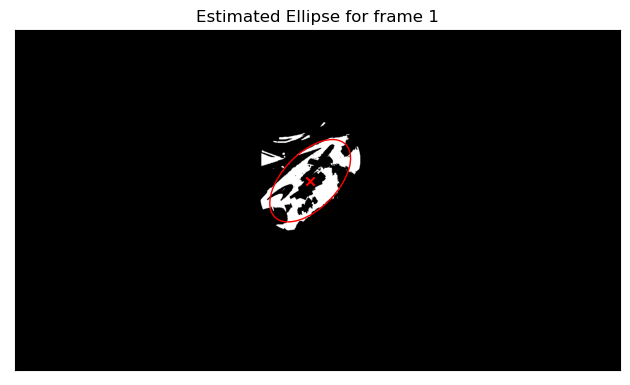

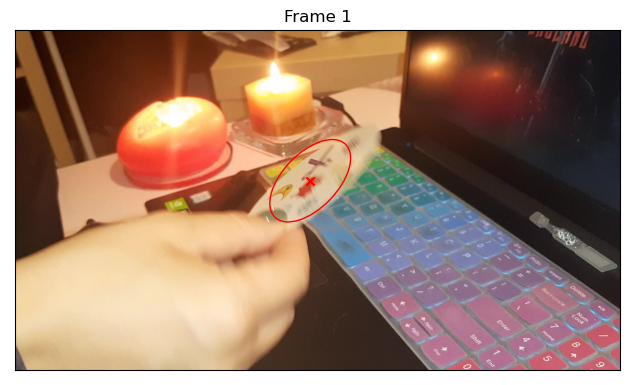

In [10]:
# define the maximum values for the parameters of an ellipse
y_max, x_max = img_gray.shape[:2]
max_axis     = round(np.sqrt(x_max**2 + y_max**2) / 5)
max_angle    = 180
max_position = [x_max, y_max, max_axis, max_axis, max_angle]

# PSO parameters for the first frame
num_particles = 15
max_iterations = 100
stop_iterations = 6     # stop if no improvement after those iterations
c1 = 1.0                # cognitive parameter
c2 = 1.0                # social parameter
w  = 0.7                # inertia weight
decay = 0.98             # decay of inertia

# run the PSO algorithm
particles = initialize_particles(img_preprocessed, num_particles, max_position)
optim = ParticleSwarmOptimizer(num_particles, max_iterations, c1, c2, w, decay, stop_iterations)
best_position, best_fitness, losses = optim.optimize(img_preprocessed, particles, max_position)

plot_loss(losses, title=f'Estimation Loss (frame {frame_num})', max_iterations=max_iterations, save_filename=None)
plot_estimation(img_preprocessed, best_position, title=f"Estimated Ellipse for frame {frame_num}", save_filename=None, est_type='ellipse', rgb=True)
plot_estimation(img, best_position, title=f"Frame {frame_num}", save_filename=None, est_type='ellipse', rgb=True)